In [1]:
#!/usr/bin/env python3.7
#coding:utf-8

# Heavily borrows from https://github.com/Priesemann-Group/covid19_inference

import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime
# import theano
# import theano.tensor as tt
import pymc3 as pm

import pickle
import datetime
import pandas as pd

import matplotlib.pyplot as plt

import theano
import theano.tensor as tt
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

import sys
sys.path.append('..')
import ModelInfo


{'epi_curve': <ModelInfo.Dataset object at 0x13a9a5910>, 'initial': <ModelInfo.Dataset object at 0x13a9a5810>}
Model starting at 2020-02-12 wed week = 7 running 87 days, offset=2
<MultiTrace: 2 chains, 200 iterations, 19 variables>
lambda_t_random_walk (400, 13) 
new_day_curve_studen (400, 4) 
lambda_0             (400,) 3.637±0.390
f_weekend            (400,) 1.103±0.069
lambda_t_sigma_rando (400,) 0.289±0.027
lambda_t             (400, 87) 
infected_t           (400, 87) 
onset_of_illness_t   (400, 87) 
w_trans              (400,) 0.078±0.013
reported_onset_of_il (400, 87) 
sigma_onset_obs      (400,) 3.194±0.354
reported_t           (400, 87, 214) 
per_day_curve_t      (400, 87, 214) 
per_day_curve_s      (400, 87, 67) 


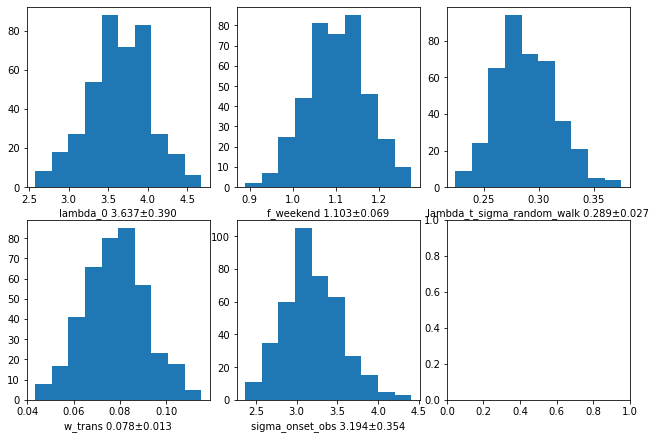

In [33]:
with open("../data/onset_by_date_missing.pickle","rb") as f:
    onsets_per_date = pickle.load(f)
    
with open("../traces/tracesimple202250_good_initial.dat","rb") as f:
    trace = pickle.load(f)
    model = pickle.load(f)
    datasets = pickle.load(f)

print(datasets.datasets)
print(model)
print(trace)
trd = {}
for name in trace.varnames:
    if "log__" not in name and "interval__" not in name:
        
        s,dt = "",trace[name]
        
        if dt.ndim == 1:
            s = "%.3f±%.3f"%(np.mean(dt,axis=0),np.std(dt,axis=0))
            trd[name] = (dt,s,)
        print((name+" "*20)[:20],trace[name].shape,s)

n2 = int(np.ceil(np.sqrt(len(trd))))
fig, axes = plt.subplots(int(len(trd)//n2+1),n2 , figsize = (n2*3,3*(len(trd)//n2+1)),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.18,left=0.05,right=0.98,top=0.96,bottom=0.05)
for i,k in enumerate(trd.keys()):
    v = trd[k]
    ax = axes[i//n2,i%n2]
    ax.hist(v[0])
    ax.set_xlabel(k+" "+v[1])

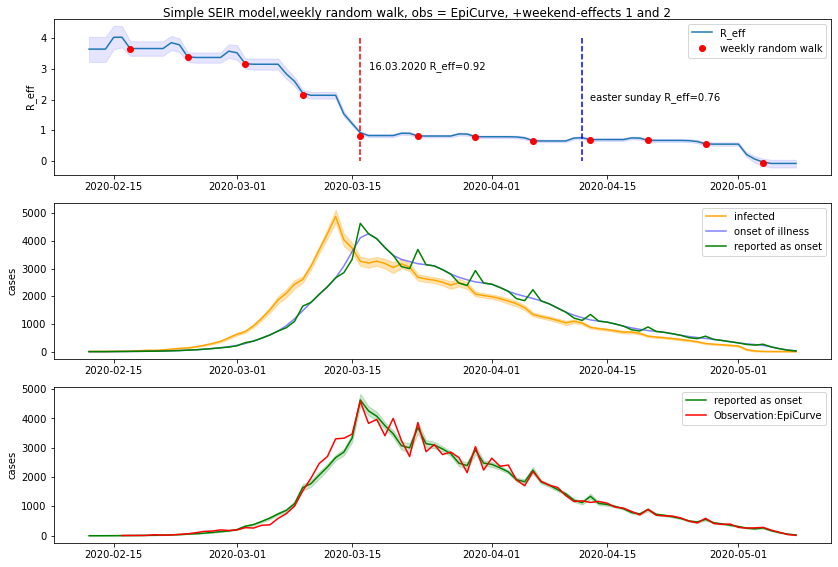

In [77]:
# Plot Time series of results
fig, axes = plt.subplots(3,1 , figsize = (12,8),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.18,left=0.08,right=0.98,top=0.96,bottom=0.05)
ax = axes[0,0]

epi_curve = datasets.datasets["epi_curve"].dataset
ts = pd.date_range(model.startdate,periods=model.length,freq='D')

fig.suptitle("Simple SEIR model,weekly random walk, obs = EpiCurve, +weekend-effects 1 and 2")
lambda_tm = np.mean(trace.lambda_t,axis=0)
ax.plot(ts,lambda_tm,label="R_eff")
ax.fill_between(ts,*np.percentile(trace.lambda_t, axis=0, q=(12.5,87.5)),color="blue",alpha=.1)
ax.plot((ts[7::7]-datetime.timedelta(days=model.weekoffset)),np.mean(trace.lambda_t_random_walk,axis=0)[1:]+np.mean(trace.lambda_0),"o",color="red",label="weekly random walk")
ax.legend()

lockdown = datetime.date(2020,3,16)
ax.plot([lockdown]*2,[4,0],"--",color="red")
ax.text(lockdown+datetime.timedelta(days=1),3,"16.03.2020 R_eff=%.2f"%lambda_tm[(lockdown-model.startdate).days])
ax.set_ylabel("R_eff")

easter = datetime.date(2020,4,12)
ax.plot([easter]*2,[4,0],"--",color="blue")
ax.text(easter+datetime.timedelta(days=1),2,"easter sunday R_eff=%.2f"%lambda_tm[(easter-model.startdate).days])

bx = axes[1,0]
bx.plot(ts,np.mean(trace.infected_t,axis=0),label="infected",color="orange")
bx.fill_between(ts,*np.percentile(trace.infected_t,axis=0,q=(12.5,87.5)),color="orange",alpha=.3)

bx.plot(ts,np.mean(trace.onset_of_illness_t,axis=0),label="onset of illness",color="blue",alpha=.5)
bx.plot(ts,np.mean(trace.reported_onset_of_illness_t,axis=0),color="green",label="reported as onset")
bx.set_ylabel("cases")
bx.legend()

cx = axes[2,0]
cx.plot(ts,np.mean(trace.reported_onset_of_illness_t,axis=0),label="reported as onset",color="green")
cx.fill_between(ts,*np.percentile(trace.reported_onset_of_illness_t,axis=0,q=(12.5,87.5)),color="green",alpha=.2)
cx.plot(ts[:len(epi_curve)],epi_curve,color="red",label="Observation:EpiCurve")
cx.set_ylabel("cases")
cx.legend()

plt.savefig("SimpleWeekendEffekts.svg")
plt.savefig("SimpleWeekendEffekts.pdf")


(400, 87, 67)
(87, 67)


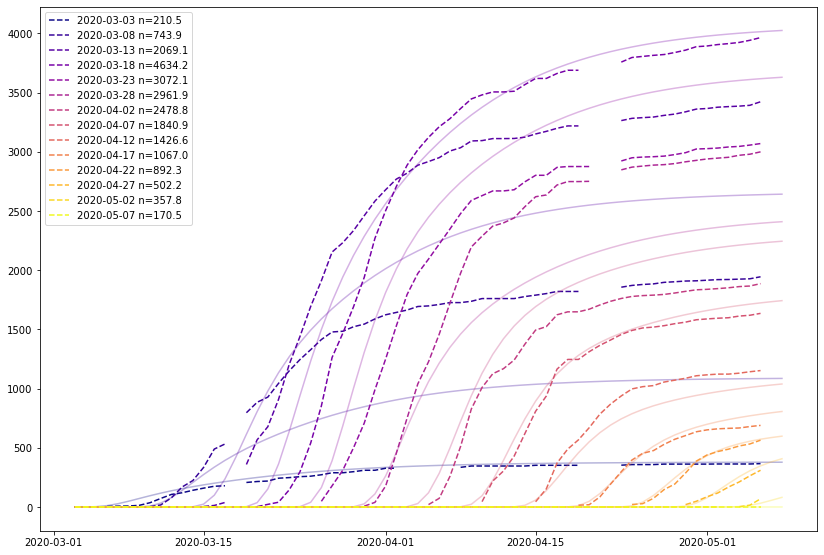

In [75]:
print(trace.per_day_curve_s.shape)
curves = np.mean(trace.per_day_curve_s,axis=0)

fig, axes = plt.subplots(1,1 , figsize = (12,8),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.18,left=0.08,right=0.98,top=0.96,bottom=0.05)
plasma = plt.cm.plasma
ax = axes[0,0]

o = 0
for i,v in enumerate(curves[20+o::5]):
    j = 20+o + i*5
    c = plasma(i/((len(curves)-20)//5))
    ax.plot(ts[20:],v,color=c,alpha=.3)
    
    m = (i+3)*5+3+o
    n = np.mean(trace.reported_onset_of_illness_t,axis=0)[m]
    ax.plot(ts[20:-2],onsets_per_date[m][:-2],"--",color=c,label="%s n=%.1f"%(("%s"%ts[j])[:10],n))
ax.legend()
print(curves.shape)

(400, 87, 67)


NameError: name 'onsets_per_date' is not defined

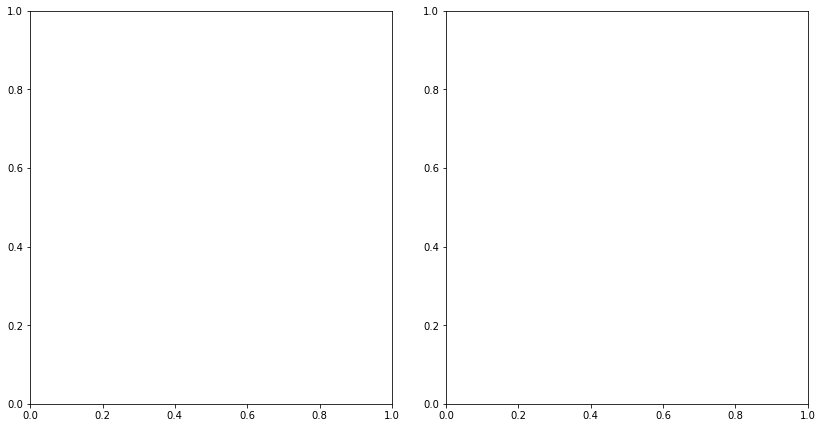

In [8]:
print(trace.per_day_curve_s.shape)

fig, axes = plt.subplots(1,2 , figsize = (12,6),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.18,left=0.08,right=0.98,top=0.96,bottom=0.05)
ax = axes[0,0]
plasma = plt.cm.plasma

for i in reversed(range(13)):
    c = plasma(i/13.)
#    ax.plot(np.mean(trace.per_day_curve_s[:,i*5],axis=0),color=c)
 #   ax.fill_between(range(trace.per_day_curve_s.shape[2]),*np.percentile(trace.per_day_curve_s[:,i*5], axis=0, q=(12.5,87.5)),color="blue",alpha=.1)

    ax.plot(onsets_per_date[i*5],"--",color=c)

bx = axes[0,1]
bx.plot(np.mean(trace.delay_ratio_t,axis=0),c="orange")
bx.fill_between(np.arange(len(trace.lambda_t[0])),*np.percentile(trace.delay_ratio_t, axis=0, q=(12.5,87.5)),color="orange",alpha=.1)
bx.plot(np.mean(trace.lambda_t,axis=0),c="blue")
bx.fill_between(np.arange(len(trace.lambda_t[0])),*np.percentile(trace.lambda_t, axis=0, q=(12.5,87.5)),color="blue",alpha=.1)
#bx.hist(trace.delay_ratio_t)
#print(trace.per_day_curve_t[0][0])

#print(np.mean(trace.lambda_t,axis=0))

In [ ]:
for i in range(8):
    plt.plot(np.mean(trace.per_day_curve_t,axis=0)[i*10])


In [ ]:
fig, axes = plt.subplots(1,2 , figsize = (12,6),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.18,left=0.05,right=0.98,top=0.96,bottom=0.05)
ax = axes[0,0]

#ax.plot(np.mean(trace.epi_curve_t,axis=0)[:60])
ax.plot(np.mean(trace.infected_t,axis=0),label="infected")
ax.plot(np.mean(trace.onset_of_illness_t,axis=0),label="onset",linewidth=2)
#plt.plot(np.mean(trace.per_day_curve_t,axis=0)[10])
for i in range(1,7):
    ax.plot(np.cumsum(np.mean(trace.per_day_curve_t,axis=0),axis=1)[10*i][:80])
    
ax.legend()
#plt.plot(np.cumsum(trace.delayed_dist[0,:],axis=0))
#plt.plot(np.cumsum(trace.delayed_t[0][:,:],axis=0)[:,::10])

#for k in range(2,9):
#    ax.plot(trace.per_day_curve_s[0][k*10-1])

bx = axes[0,1]
_ = bx.hist(np.mean(trace.delay_ratio_t,axis=0))

In [ ]:
#epi_curve = [7, 11, 8, 10, 34, 22, 26, 46, 65, 103, 147, 155, 195, 177, 193, 268, 255, 349, 363, 575, 744, 989, 1502, 1924, 2394, 2651, 3240, 3261, 3385, 4518, 3753, 3900, 3343, 3923, 3202, 2636, 3777, 2803, 3045, 2707, 2764, 2619, 2113, 2970, 2186, 2575, 2298, 2356, 1861, 1668, 2135, 1810, 1659, 1612, 1311, 1134, 1136, 1095, 1130, 1061, 933, 894, 795, 667, 834, 647, 614, 589, 515, 415, 351, 430, 295, 211, 160, 45, 18, 10, 2]
epi_curve = [0,0,0,0]+[7, 9, 8, 10, 33, 19, 26, 45, 64, 102, 147, 158, 197, 179, 195, 272, 258, 350, 366, 585, 747, 997, 1521, 1944, 2421, 2672, 3272, 3282, 3422, 4546, 3778, 3929, 3376, 3964, 3220, 2659, 3822, 2826, 3069, 2737, 2798, 2644, 2144, 2999, 2210, 2597, 2332, 2384, 1886, 1683, 2165, 1835, 1689, 1635, 1342, 1154, 1171, 1122, 1152, 1090, 959, 919, 819, 689, 874, 681, 641, 634, 564, 460, 402, 516, 370, 310, 274, 158, 125, 104, 69, 11, 1, 0]
#epi_curve = [0]*4+epi_curve
epi_curve = ma.masked_less(epi_curve,0.,copy=True)

initial_obs_rki_sit = [9.188,9.188,4.594,4.594,22.971,13.783,27.565,27.565,27.565,53.507,32.821]+[x*.8 for x in [30,17,16,36]+[63.072,106.910,163.956,231.851,306.731,383.947,458.793,527.101,585.620,632.178,665.686,686.005,693.759,690.122,676.616,654.935,626.805,593.878,557.666,519.498,480.503,441.606,403.541,366.868,331.992,299.187,268.619,240.364,214.431,190.776,169.313,149.934,132.509,116.901,102.965,90.561,79.549,69.796,61.177,53.573,46.877,40.989,35.819,31.284,27.311,23.833,20.792,18.134,15.812,13.785,12.017,10.475,9.130,7.958,6.937,6.047,5.272,4.596,4.008,3.496,3.049]]#,2.661,2.322]#,2.027,1.770]
imported_cases = np.asarray(initial_obs_rki_sit[:len(epi_curve)],dtype=np.float64)
hospital = [-1]*17+[-1]*20+[379,352,529,581,661,432,566,719,759,834,839,748,747,500,676,751,791,789,604,468,425,415,644,705,645,660,428,310,405,569,500,490,410,286,160,296,360,379,470,192] 
hospital = ma.masked_less(hospital,0.,copy=True)

deaths = [-1]*17+[-1,-1,-1,-1,-1,-1,0,1,2,0,3,4,0,0,0,8,11,16,8,31,28,35,49,55,72,64,66,128,149,140,145,141,184,92,173,254,246,266,171,129,126,170,285,315,299,242,184,110,194,281,215,227,179,140,110,163,202,173,193,94,74,43,139,165]#deaths = [0]*4+deaths
deaths = np.asarray(deaths,dtype=np.float64)

icu_deaths = [-1]*17+[-1]*36+[93,154,0,131,88,66,228,255,305,123,50,59,108,91,115,39,22,29,24,68,69,52,40,46]
icu_deaths_begin = 17+30
icu_deaths = ma.masked_less(icu_deaths,0.,copy=True)

print(len(epi_curve),len(hospital),len(deaths),len(icu_deaths))

time_arr=pd.date_range(datetime.date(2020,2,12), periods=trace.infected_t.shape[1], freq='D')
time_arrL=pd.date_range(datetime.date(2020,2,12), periods=trace.lambda_t.shape[1]+10, freq='D')
dtx = [datetime.date(2020,3,1),datetime.date(2020,3,15),datetime.date(2020,4,1),datetime.date(2020,4,15),datetime.date(2020,5,1)]

fig, axes = plt.subplots(2, 1, figsize = (12,8),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.14,left=0.05,right=0.98,top=0.96,bottom=0.05)
fig.suptitle('Estimates for (known!) EpiCurve, hospitalization and deaths')
ax = axes[0,0]
bx = axes[1,0]
cx = fig.add_axes([.11,.15,.27,.27])

ax.plot(time_arrL[:len(epi_curve)],epi_curve,color="red",label="EpiCurve")
ax.plot(time_arr,np.median(trace.onset_of_illness_t,axis=0),color="blue",alpha=.5)
ax.fill_between(time_arr,*np.percentile(trace.onset_of_illness_t, axis=0, q=(12.5,87.5)),color="blue",alpha=.1)
#ax.plot(time_arrL[:len(initial_obs_rki_sit)],initial_obs_rki_sit,c="purple",label="Imported")
#ax.plot(time_arrL,np.sum(np.mean(trace.per_day_curve_t,axis=0),axis=0)[:93],label="reported")
ax.set_ylabel("cases per day")
ax.legend(loc=1)
ax.set_xticks(dtx)
ax.set_xticklabels(dtx)

if False:
#    ax.plot(time_arr[:len(trace.initial_t)],trace.initial_t,color="red",label="deaths")
    ax.plot(time_arr,np.median(trace.initial_t,axis=0),color="orange")
    ax.fill_between(time_arr,*np.percentile(trace.initial_t, axis=0, q=(12.5,87.5)),color="orange",alpha=.2)

if False:
    bx.plot(time_arrL[:len(hospital)],hospital,color="cyan",label="hospitalization")
    bx.plot(time_arr[37:],np.median(trace.hosp_t,axis=0),color="green")
    bx.fill_between(time_arr[37:],*np.percentile(trace.hosp_t, axis=0, q=(12.5,87.5)),color="green",alpha=.2)

if True:
    bx.plot(time_arr[:len(deaths)],deaths,color="red",label="deaths")
    bx.plot(time_arr,np.median(trace.dead_t,axis=0),color="orange")
    bx.fill_between(time_arr,*np.percentile(trace.dead_t, axis=0, q=(12.5,87.5)),color="orange",alpha=.2)


    
if False:
    bx.plot(time_arrL[:len(icu_deaths)],icu_deaths,color="black",label="ICU_deaths")
    bx.plot(time_arr[icu_deaths_begin:],np.median(trace.ICU_dead_t,axis=0),color="grey")
    bx.fill_between(time_arr[icu_deaths_begin:],*np.percentile(trace.ICU_dead_t, axis=0, q=(12.5,87.5)),color="grey",alpha=.2)

bx.set_ylabel("cases per day")
bx.legend(loc=1)
bx.set_xticks(dtx)
bx.set_xticklabels(dtx)


cx.set_title("R_eff")
cx.plot(time_arrL[:len(trace.lambda_t[0])],np.median(trace.lambda_t,axis=0))
cx.fill_between(time_arrL[:len(trace.lambda_t[0])],*np.percentile(trace.lambda_t, axis=0, q=(12.5,87.5)),color="blue",alpha=.1)
cx.set_xticks(dtx)
cx.set_xticklabels(dtx,rotation=20,horizontalalignment='right')

#plt.savefig("EstEpiCurve.pdf")

In [ ]:
#plt.hist(trace.lambda_0)
t = trace
dh = {"lambda0":t.lambda_0,"m_incubation":t.median_incubation}
#dh.update({"f_death":t.f_death,"m_death":t.m_death})
#dh.update({"f_hospital":t.f_hospital,"m_hospital":t.m_hospital})
#dh.update({"f_ICU_death":t.f_ICU_death,"m_ICU_death":t.m_ICU_death})
hy = int(np.ceil(len(dh)/2.))
fig, axes = plt.subplots(hy,2+1 , figsize = (8+4,4*hy),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.18,left=0.05,right=0.98,top=0.96,bottom=0.05)

for i,k in enumerate(dh.keys()):
    d = dh[k]
    ax = axes[i//2,i%2]
    ax.hist(d,bins=30)
    ax.set_xlabel(k)

#obs = {"e_infected":t.sigma_obs,"e_hospital":t.sigma_obs_hospital,"e_dead":t.sigma_obs_dead}
obs = {"e_infected":t.sigma_obs}#,"e_dead":t.sigma_obs_dead}
for i,k in enumerate(obs.keys()):
    print(k)
    ax = axes[i,2]
    d = obs[k]
    ax.hist(d,bins=30)
    ax.set_xlabel(k)
        
#plt.hist(trace.f_hospital,bins=30)

In [ ]:
dhf,dhk = [],[k for k in dh.keys()]
for i,k1 in enumerate(dhk):
    for j,k2 in enumerate(dhk[i+1:]):
        dhf.append( (k1,k2,i,j,dh[k1],dh[k2],) ) 
                   
fig, axes = plt.subplots(len(dhk)-1,len(dhk)-1 , figsize = (12,12),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.18,left=0.05,right=0.98,top=0.96,bottom=0.05)
plasma = plt.cm.plasma

l = len(dh[dhk[0]])
cp = [plasma(x )for x in np.linspace(0,1,l)]

for k1,k2,i,j,d1,d2 in dhf:
    ax = axes[i,i+j]
    if i == 0:
        ax.set_title(k2)
    if j == 0:
        ax.set_ylabel(k1)
    ax.scatter(d1,d2,color=cp,alpha=.1)

In [ ]:
trace.stat_names
trace.tree_size


In [ ]:
print(",".join(["%.3f"%x for x in np.mean(trace.lambda_t,axis=0)]) ) 

In [ ]:
plt.hist(np.mean(trace.new_day_curve_studentT_missing,axis=0))

In [ ]:
np.mean(trace.delayed_distr,axis=0)

fig, axes = plt.subplots(2, 1, figsize = (12,8),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.14,left=0.05,right=0.98,top=0.96,bottom=0.05)
ax = axes[0,0]
ax.plot(np.mean(trace.delayed_distr,axis=0))
ax.fill_between(np.arange(64),*np.percentile(trace.delayed_distr, axis=0, q=(12.5,87.5)),color="grey",alpha=.2)
bx = axes[1,0]
for i in range(10):
    bx.plot(np.cumsum(trace.delayed_distr[i*10]))

In [ ]:
plt.hist(trace.sigma_delayed_obs)

In [ ]:
trace.varnames

In [ ]:
plt.plot(trace.lambda_0)